In [3]:
import sys
import os
import pandas as pd
from pytablewriter import MarkdownTableWriter
from typing import Dict, List, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

%config Completer.use_jedi = False

In [4]:
#ALGORITHM = ["semantic-zest", "syntactic-zest", "semantic-noguidance", "syntactic-noguidance"]
ALGORITHM = ["semantic-noguidance","semantic-zest", "syntactic-noguidance", "syntactic-zest", "afl"]

RANGE=20 #exclusiove range in python

folder = "expfinalfinal"
base_path = f"c:\\Users\\Alena\\source\\repos\\growe\\{folder}\\"


pdf_dir=f'pdfs_{folder}/'

if not os.path.exists(os.path.join(".",pdf_dir)):
    os.mkdir(os.path.join(".",pdf_dir))


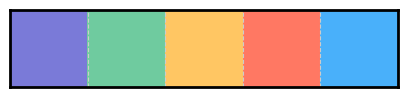

In [5]:
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", font_scale=1.5)

plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 
                     'axes.grid': True, 'grid.linestyle': '--'})
colors = ['#7a7ad8', '#6fcb9f', '#ffc663', '#ff7863', '#49B0FA']
sns.palplot(colors)
sns.set_palette(sns.color_palette(colors), 8, .75)
sub_figure_title = {"fontweight": 700, 'fontname':'Arial', 'fontsize': 18}
#plt.tight_layout()







In [6]:

def process_cov_data(path: str) -> List[str]:
    with open(path) as f:
        return f.readlines()

In [7]:
#read cov-all and cov-valid

cov_data_count = {
    "algo": [],
    "type": [],
    "value": []
}

cov_all_data = []
cov_valid_data = []

def read_this(path, typ):
    cov = process_cov_data(path)
    cov_data_count["algo"].append(algorithm)
    cov_data_count["type"].append(typ)
    cov_data_count["value"].append(len(cov))

    if len(cov) > 0: 
        splits = [c.replace('# Covered: (','').split(') ') for c in cov]
        data = np.array(splits)
        cov,calls = data.T
        method=[c.split('()')[0] for c in calls]
        clazz=[c.split('#')[0] for c in method]
        clazz=[c.split('$')[0] for c in clazz]
        
        cov_int = [int(i) for i in cov]
        
        df=pd.DataFrame({'cov':cov_int, 'clazz':clazz,'method':method,'calls':calls})
        df['clazz'] = pd.Categorical(df['clazz'], categories=set(clazz))
        df['method'] = pd.Categorical(df['method'], categories=set(method))
        
        
        #df.columns = ['cov','class']
        df['algorithm']=[algorithm]*len(cov)

        return df
    return pd.DataFrame()
        

for algorithm in ALGORITHM:
    cov_all_data_algo = []
    cov_valid_data_algo = []

    for idx in range(0, RANGE):
        path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}", "errorDir")
        if algorithm == "afl":
            path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}","fuzz-results")
        if not os.path.exists(path):
            continue
        #print(f"processing: {path}")

        #read cov all
        cov_all_path = os.path.join(path, "cov-all.log")
        if not os.path.exists(cov_all_path): continue
        
        df = read_this(cov_all_path,"all")
        if not df.empty:
            df['run']= [idx] * df.shape[0]
            cov_all_data_algo.append(df)

        
        #read cov valid
        cov_valid_path = os.path.join(path, "cov-valid.log")
        if not os.path.exists(cov_valid_path): continue
        
        df = read_this(cov_valid_path,"valid")
        if not df.empty: 
            df['run']= [idx] * df.shape[0]
            cov_valid_data_algo.append(df)

    if cov_valid_data_algo:
        cov_valid_data.append(pd.concat( cov_valid_data_algo))
    if cov_all_data_algo:
        cov_all_data.append(pd.concat( cov_all_data_algo))

    
cov_valid_data = pd.concat( cov_valid_data)
cov_all_data = pd.concat( cov_all_data)

In [8]:
cov_all_data[cov_all_data['algorithm'] == 'stream-zest']

,cov,clazz,method,calls,algorithm,run


In [9]:
#sns.displot(cov_all_data, x='cov', hue="algorithm", kind='kde')
#sns.displot(cov_valid_data, x='cov', hue="algorithm", kind='kde')


In [10]:
sns.set_theme(style="whitegrid")

#f, ax = plt.subplots(figsize=(48, 8))
#sns.despine(f, left=True, bottom=True)
#sorted_data= cov_all_data.sort_values(by=['clazz'])
#sns.scatterplot(sorted_data,y='cov',x='clazz',hue="algorithm",ax=ax)
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha='right')

In [11]:
#f, ax = plt.subplots(figsize=(48, 8))


#sns.despine(f, left=True, bottom=True)
#sorted_all_cov=cov_all_data.sort_values(by=['clazz'])
#sns.scatterplot(sorted_all_cov,y='algorithm',x='clazz',ax=ax)
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, ha='right')

C:\Users\Alena\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


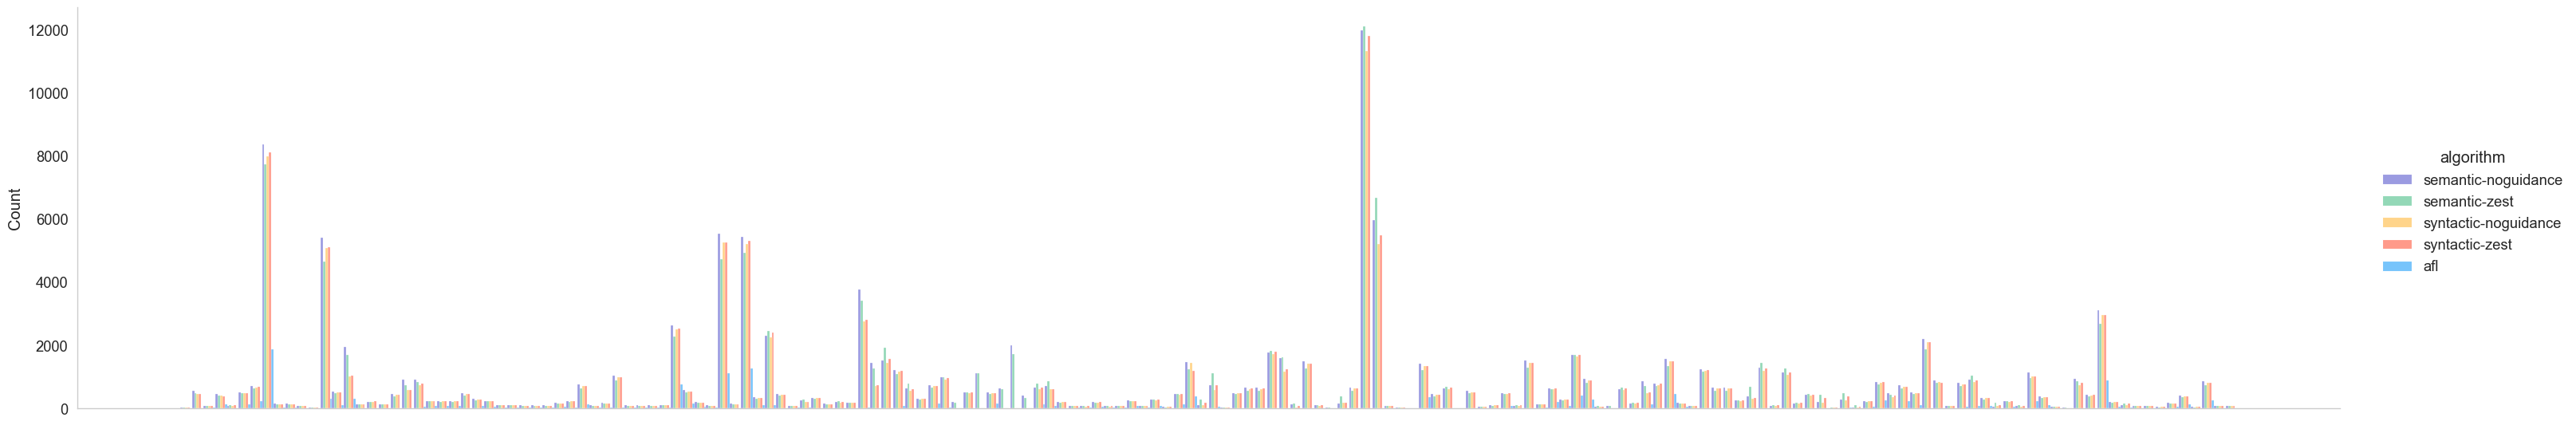

In [28]:

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", font_scale=1.5)
sorted_val_cov=cov_valid_data.sort_values(by=['clazz'])

plot = sns.displot(sorted_val_cov,x="clazz", hue="algorithm",  hue_order=ALGORITHM, palette=colors, height=6, aspect=5, multiple="dodge")
plot.set(xticklabels=[])
plot.set(xlabel=None)




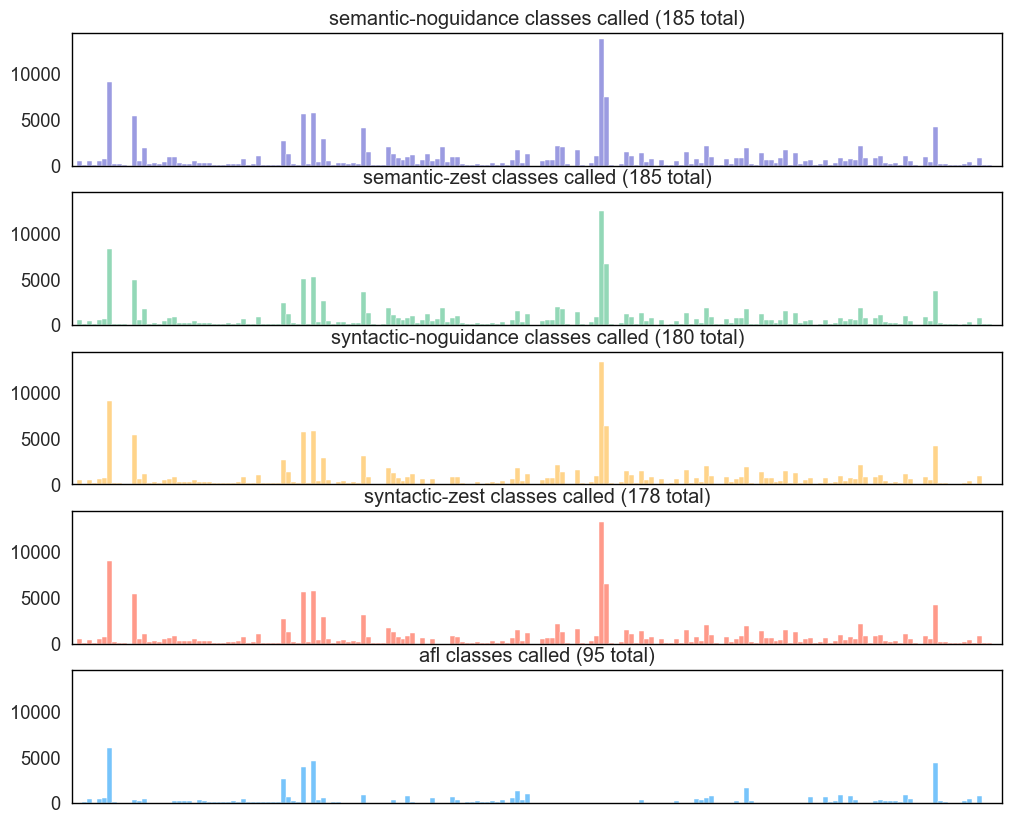

In [35]:
i=0
plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 1, 
                     'axes.grid': False, 'grid.linestyle': '--'})
ll , ax = plt.subplots(5,1, sharey=True, sharex=True, figsize=(12,10))
sorted_cov=cov_all_data.sort_values(by=['clazz'])
for algo in ALGORITHM:
    algodata= sorted_cov[sorted_cov['algorithm']==algo]
    plot = sns.histplot(algodata["clazz"], color=colors[i], ax=ax[i])
    c = len(algodata['clazz'].value_counts())
    plot.set(xticklabels=[])
    plot.set(xlabel=None)
    plot.set(ylabel=None)

    plot.margins(x=0)
    plot.set_title(f'{algo} classes called ({c} total)')
    i+=1
ll.savefig(f'{pdf_dir}/classes_called.pdf',bbox_inches = 'tight', pad_inches = 0.1)

C:\Users\Alena\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


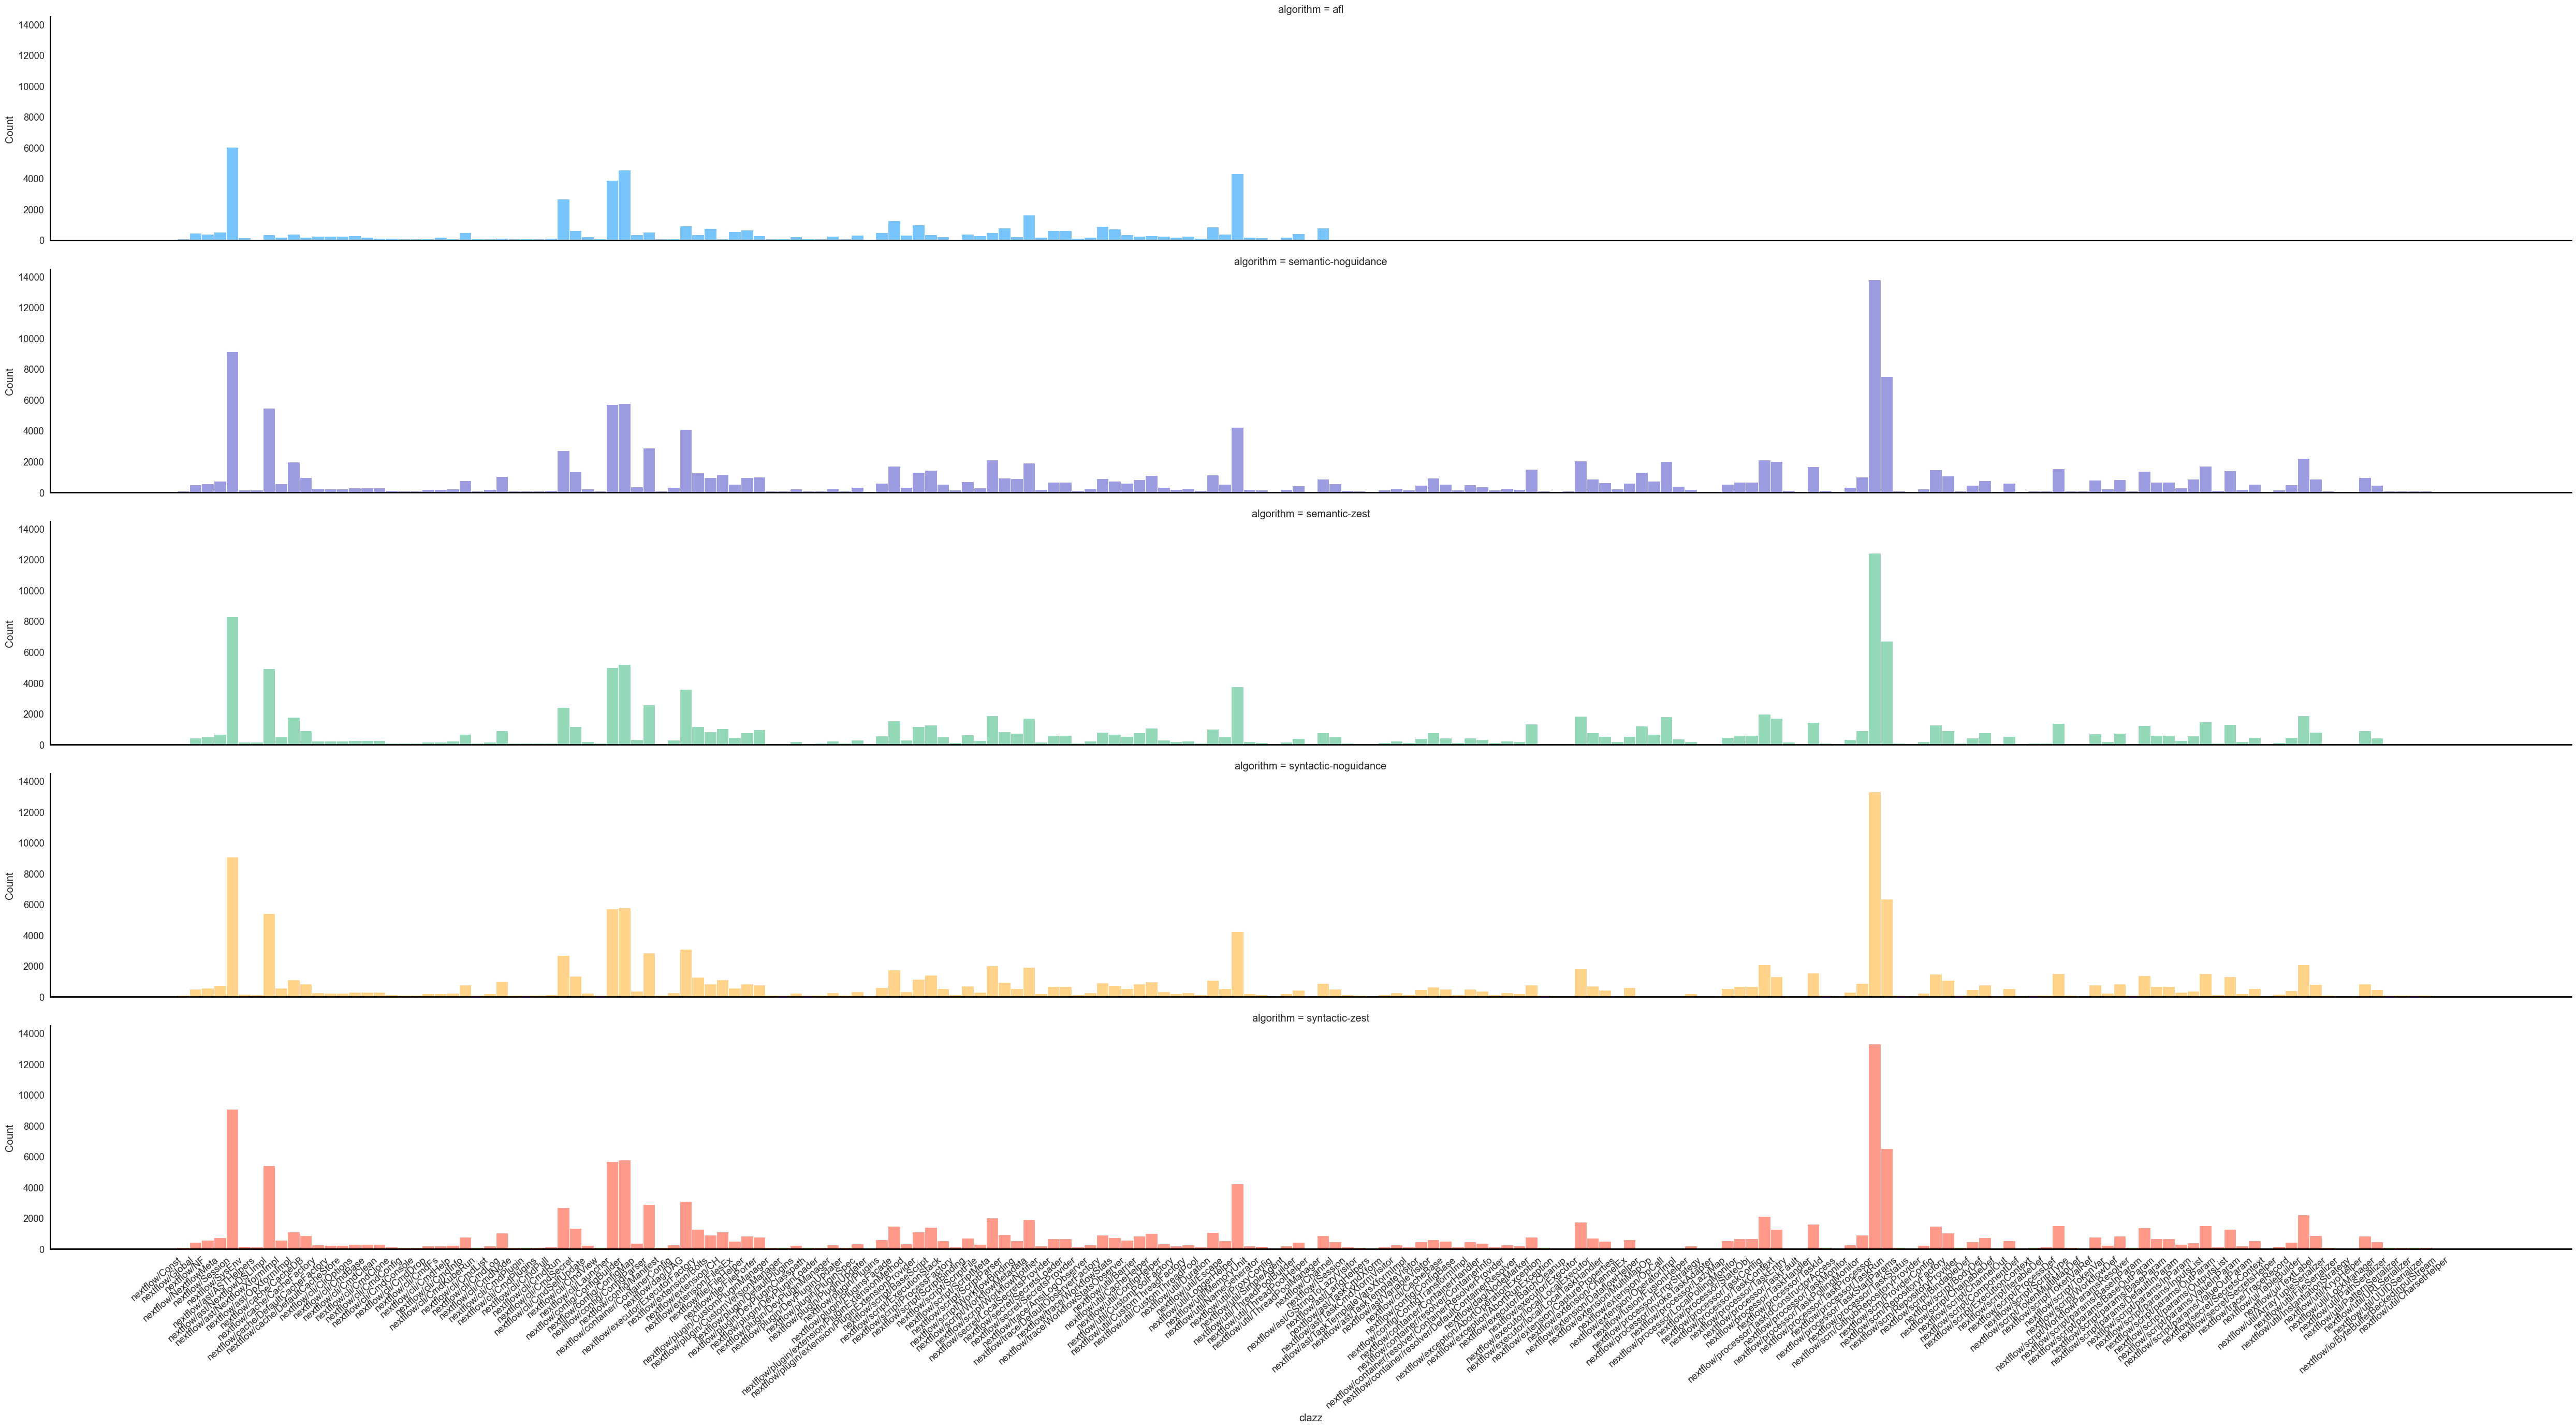

In [26]:

sorted_val_cov=cov_all_data.sort_values(by=['clazz'])

plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 
                     'axes.grid': False, 'grid.linestyle': '--'})

g = sns.FacetGrid(sorted_val_cov, row='algorithm', hue='algorithm', hue_order=ALGORITHM, palette=colors, row_order=sorted(sorted_val_cov['algorithm'].unique()),height=5, aspect=10)
g.map(sns.histplot, 'clazz')

#g.set(xticklabels=[])
#g.set(xlabel=None)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(40)
        label.set_ha('right')

In [51]:
g.savefig(f'{pdf_dir}/class_hist_called.pdf')

In [14]:
from matplotlib_venn import venn2,venn3


def venn2_this(df,column,a,b,on):
# Create subsets for category A and B
    set_a = set(df[df[column].str.contains(a)][on])
    set_b = set(df[df[column].str.contains(b)][on])
    
    # Create a Venn diagram
    venn2([set_a, set_b], (a, b))
    
    # Display the diagram
    plt.title(f'{on} for {a} and {b}')
    plt.show()

def venn3_this(df,column,a,b,c,on):
# Create subsets for category A and B
    set_a = set(df[df[column].str.contains(a)][on])
    set_b = set(df[df[column].str.contains(b)][on])
    set_c = set(df[df[column].str.contains(c)][on])
    
    # Create a Venn diagram
    venn3([set_a, set_b, set_c], (a, b,c))
    
    # Display the diagram
    plt.title(f'{on} for {a}, {b} and {c}')
    plt.show()



532
532


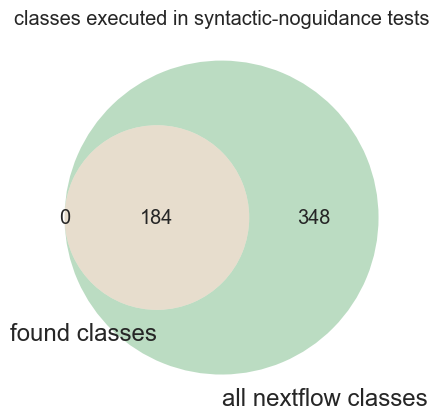

In [15]:
strings_file = "nextflowclasses.txt"


# Create empty output files
found_strings = []
not_found_strings = []
all_classes =[]
algorithm = "syntactic-noguidance"
cov_data_set = set(cov_all_data[cov_all_data['algorithm'].str.contains(algorithm)]['calls'].values)
# Read strings from strings_file and search for them in the DataFrame column 'clazz'
with open(strings_file, 'r') as file:
    for line in file:
        search_string = line.strip()
        all_classes.append(search_string)
        if np.any([search_string in entry for entry in cov_data_set]):
            found_strings.append(search_string)
        else:
            not_found_strings.append(search_string)

print(len(all_classes))

print(len(set(all_classes)))
plot= venn2([set(found_strings),set(all_classes)],("found classes","all nextflow classes"))
if algorithm=='a' : algorithm ='all' 
plt.title(f'classes executed in {algorithm} tests')
plt.savefig(f"{pdf_dir}/classes_found_{algorithm}.pdf")

In [16]:
sem  = set(cov_all_data[cov_all_data['algorithm'].str.contains('syntactic-noguidance')]['clazz'].values)
syn  = set(cov_all_data[cov_all_data['algorithm'].str.contains('semantic-zest')]['clazz'].values)

for s in syn:
    if s not in sem:
        print(s) 

print('--')

for s in sem:
    if s not in syn:
        print(s) 


nextflow/processor/ErrorStrategy
nextflow/extension/OpCall
nextflow/extension/OperatorImpl
nextflow/script/TokenMultiMapDef
nextflow/extension/DataflowHelper
nextflow/extension/MultiMapOp
nextflow/extension/CaptureProperties
--
nextflow/util/CharsetHelper
nextflow/io/ByteBufferBackedInputStream


In [17]:
'''
venn3_this(cov_valid_data,'algorithm','semantic','syntactic','afl','cov')
venn3_this(cov_all_data,'algorithm','semantic','syntactic','afl','clazz')

venn3_this(cov_valid_data,'algorithm','zest','noguidance','afl','cov')
venn3_this(cov_all_data,'algorithm','zest','noguidance','afl','cov')

venn3_this(cov_all_data,'algorithm','semantic','syntactic','stream','cov')
'''


"\nvenn3_this(cov_valid_data,'algorithm','semantic','syntactic','afl','cov')\nvenn3_this(cov_all_data,'algorithm','semantic','syntactic','afl','clazz')\n\nvenn3_this(cov_valid_data,'algorithm','zest','noguidance','afl','cov')\nvenn3_this(cov_all_data,'algorithm','zest','noguidance','afl','cov')\n\nvenn3_this(cov_all_data,'algorithm','semantic','syntactic','stream','cov')\n"

In [18]:
'''
venn3_this(cov_valid_data,'algorithm','semantic','syntactic','afl','method')
venn3_this(cov_valid_data,'algorithm','zest','noguidance','afl','method')

venn3_this(cov_all_data,'algorithm','semantic','syntactic','afl','method')
venn3_this(cov_valid_data,'algorithm','semantic','syntactic','afl','method')
'''

"\nvenn3_this(cov_valid_data,'algorithm','semantic','syntactic','afl','method')\nvenn3_this(cov_valid_data,'algorithm','zest','noguidance','afl','method')\n\nvenn3_this(cov_all_data,'algorithm','semantic','syntactic','afl','method')\nvenn3_this(cov_valid_data,'algorithm','semantic','syntactic','afl','method')\n"

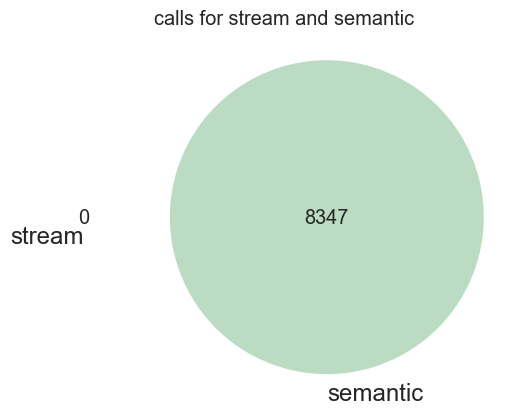

In [19]:
venn2_this(cov_all_data,'algorithm','stream','semantic','calls')


<Axes: >

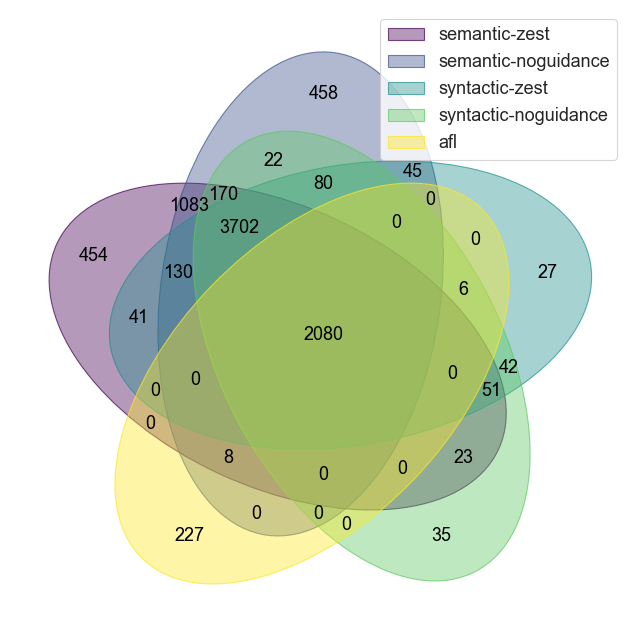

In [20]:
from venn import venn
%matplotlib inline
df=cov_all_data
column='algorithm'
on='calls'
a='semantic-zest'
b='semantic-noguidance'
c='syntactic-zest'
d='syntactic-noguidance'
e='afl'
#f='stream'
data = {
    a : set(df[df[column].str.contains(a)][on]),
    b : set(df[df[column].str.contains(b)][on]),
    c : set(df[df[column].str.contains(c)][on]),
    d : set(df[df[column].str.contains(d)][on]),
    e : set(df[df[column].str.contains(e)][on]),
 #   f : set(df[df[column].str.contains(f)][on]),
    
}

venn(data)


<Axes: >

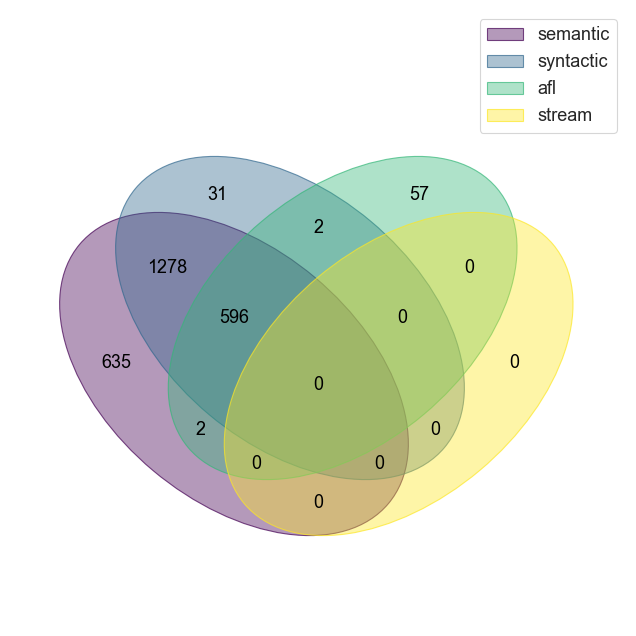

In [21]:
from venn import venn
%matplotlib inline
df=cov_all_data
column='algorithm'
on='method'
a='semantic'
c='syntactic'
e='afl'
f='stream'
data = {
    a : set(df[df[column].str.contains(a)][on]),
    c : set(df[df[column].str.contains(c)][on]),
    e : set(df[df[column].str.contains(e)][on]),
    f : set(df[df[column].str.contains(f)][on]),
    
}

venn(data)

In [36]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 10
            value = str(int(p.get_height()))
            ax.text(_x, _y, value, ha="center")

    if isinstance(axs, np.ndarray):
        for _, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def generate_total_coverage_bar(data: Dict[str, List[Any]], path: str):
    f, ax = plt.subplots(figsize=(9,5))
    pal= sns.color_palette(colors)
    axis = sns.barplot(x="type", y="value", hue="algo", data=data,  hue_order=ALGORITHM, errorbar="ci", ax=ax, palette=colors)
    show_values_on_bars(axis)
    axis.legend(loc='center left')
    
    fig = axis.get_figure()
    fig.savefig(path,  bbox_inches = 'tight', pad_inches = 0.1)
    #fig.clf()
    fig.show()



C:\Users\Alena\AppData\Local\Temp\ipykernel_14808\3481251439.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


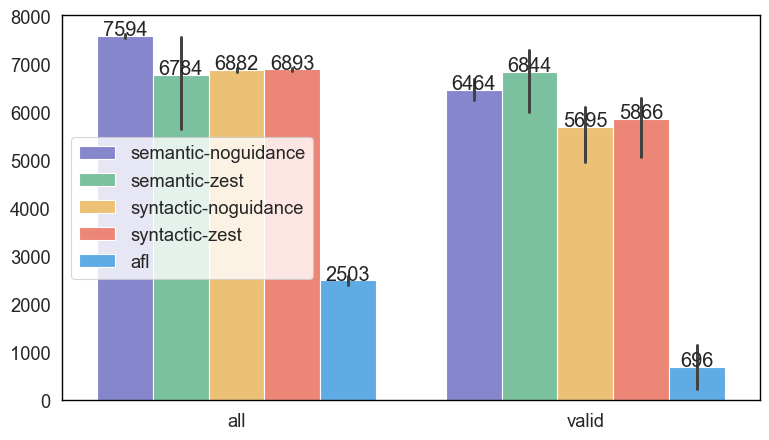

In [37]:

generate_total_coverage_bar(cov_data_count, f'{pdf_dir}/cov_data_count.pdf')


In [49]:
pd.DataFrame(cov_data_count).groupby(['algo','type']).describe()

value                                             \
                           count         mean          std     min      25%   
algo                 type                                                     
afl                  all    20.0  2503.150000   223.676052  2361.0  2361.00   
                     valid  20.0   696.250000  1091.179414     0.0     0.00   
semantic-noguidance  all    20.0  7594.650000    92.572177  7406.0  7536.75   
                     valid  20.0  6464.250000   499.523549  6065.0  6139.25   
semantic-zest        all    20.0  6784.650000  2328.867113     0.0  7468.00   
                     valid  18.0  6844.666667  1715.924858     0.0  7164.75   
syntactic-noguidance all    20.0  6882.900000    82.512455  6628.0  6850.00   
                     valid  20.0  5695.850000  1398.351333     0.0  5709.25   
syntactic-zest       all    20.0  6893.950000    77.146801  6790.0  6836.25   
                     valid  20.0  5866.900000  1450.358899     0.0  5646.00   

                                                     
                               50%      75%     max  
algo                 type                            
afl                  all    2361.0  2807.00  2887.0  
                     valid     0.0  2309.00  2334.0  
semantic-noguidance  all    7594.5  7638.75  7768.0  
                     valid  6190.0  7013.75  7346.0  
semantic-zest        all    7550.0  7609.75  7865.0  
                     valid  7234.5  7325.50  7557.0  
syntactic-noguidance all    6881.5  6932.25  7010.0  
                     valid  5718.0  6445.75  6607.0  
syntactic-zest       all    6888.5  6923.00  7078.0  
                     valid  6467.0  6537.75  6747.0

<Axes: >

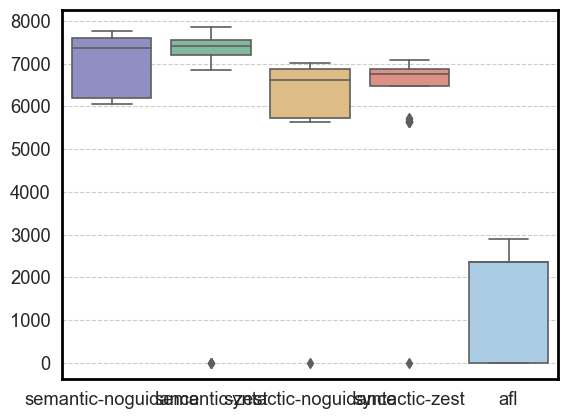

In [45]:
sns.boxplot(data=cov_data_count, x='algo', y='value')

In [24]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100


In [25]:
df =pd.DataFrame(cov_data_count)
print(df.groupby(['algo','type']).agg({'value':['std','min','max','mean']}))
df.groupby(['algo','type']).agg({'value': lambda x: cv(x) })

                                  value                         
                                    std   min   max         mean
algo                 type                                       
afl                  all     223.676052  2361  2887  2503.150000
                     valid  1091.179414     0  2334   696.250000
semantic-noguidance  all      92.572177  7406  7768  7594.650000
                     valid   499.523549  6065  7346  6464.250000
semantic-zest        all    2328.867113     0  7865  6784.650000
                     valid  1715.924858     0  7557  6844.666667
syntactic-noguidance all      82.512455  6628  7010  6882.900000
                     valid  1398.351333     0  6607  5695.850000
syntactic-zest       all      77.146801  6790  7078  6893.950000
                     valid  1450.358899     0  6747  5866.900000


value
algo                 type             
afl                  all      8.935783
                     valid  156.722357
semantic-noguidance  all      1.218913
                     valid    7.727479
semantic-zest        all     34.325531
                     valid   25.069517
syntactic-noguidance all      1.198804
                     valid   24.550354
syntactic-zest       all      1.119051
                     valid   24.721043

In [26]:
afl = cov_valid_data[cov_valid_data['algorithm'] == 'afl']
afl.groupby(['run'])['calls'].count()

run
0     2324
2     2334
4     2315
7     2327
9     2318
18    2307
Name: calls, dtype: int64

In [28]:
d= cov_all_data[cov_all_data['algorithm']=='afl']
d = d.groupby(['run'])['calls'].count()
print(d.mean())
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100
print(cv(d))
print(d.std())

2503.15
8.935783000347685
223.67605217320312


In [34]:
fuzzer_stats ={
"start_time"        : [], 
"last_update"       : [], 
"fuzzer_pid"        : [], 
"cycles_done"       : [], 
"execs_done"        : [], 
"execs_per_sec"     : [], 
"paths_total"       : [], 
"paths_favored"     : [], 
"paths_found"       : [], 
"paths_imported"    : [],     
"max_depth"         : [], 
"cur_path"          : [], 
"pending_favs"      : [], 
"pending_total"     : [], 
"variable_paths"    : [],     
"stability"         : [], 
"bitmap_cvg"        : [], 
"unique_crashes"    : [],     
"unique_hangs"      : [], 
"last_path"         : [], 
"last_crash"        : [], 
"last_hang"         : [], 
"execs_since_crash" : [],     
"exec_timeout"      : [], 
"afl_banner"        : [], 
"afl_version"       : [], 
"target_mode"       : [], 
"command_line"      : []    
}

for i in range(0,RANGE):
    path = os.path.join(base_path, f"nextflow-afl-{i}", "fuzz-results","fuzzer_stats")
    data = process_cov_data(path)
    splits = [l.split(':') for l in data ]
    for s,n in splits:
        stat = n.strip()
        fuzzer_stats[s.strip()].append(int(stat) if stat.isdecimal() else stat)
ndanf = pd.DataFrame(fuzzer_stats)

print(ndanf['execs_done'].describe())
print(cv(ndanf['execs_done']))


count      20.000000
mean     4086.950000
std        60.350271
min      3972.000000
25%      4051.000000
50%      4082.000000
75%      4127.000000
max      4204.000000
Name: execs_done, dtype: float64
1.4766579342122717


In [31]:
print(ndanf['bitmap_cvg'].describe())



count        20
unique        4
top       3.47%
freq         14
Name: bitmap_cvg, dtype: object
